# Test model
This notebook is used to load the test features and predict the labels and confidence using the trained model.
The labels are then saved in a csv file. (Its name is defined in the constant `PRED_FILE`).

Finally, the predictions will be evaluated and saved in the evaluation file with the given NAME as index.

Parameters :
- MODEL_NAME : the name of the model to load
- FEATURES_FILE : the name of the csv containing the features of bimbas
- PRED_FILE : the name of the file to save the predictions (Set None if you don't want to save the predictions)
- EVAL_FILE : the name of the csv to save the evaluation
- NAME : the name of the evaluation (used as index in the evaluation file)

We will compare the predictions made with the real labels and compute the following metrics:
- recall
- precision
- weighted f1-score
- accuracy
- roc-auc
- num_contributors
- tn_fp_fn_tp

In [1]:
import joblib
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score


In [41]:
RESOURCE_FOLDER = '../resources'
DATA_FOLDER = f'{RESOURCE_FOLDER}/data/gitlab'
MODEL_FOLDER = f'{RESOURCE_FOLDER}/models'
EVAL_FOLDER = f'{RESOURCE_FOLDER}/evals'

FEATURES_FILE = 'gitlab_glmap_features.csv'
MODEL_NAME = 'bimbis.joblib'

PRED_FILE = 'bimbis-glmap_predictions.csv'
EVAL_FILE = 'evaluation_gitlab.csv'
NAME = 'bimbis' # Name for the line in the evaluation file
MAPPING_NAME = 'glmap' # Name of the mapping used in the evaluation

RAND_SEED = 42

# 1 - Load features and labels

,label,origin,NA,NT,NR,NOR,ORR,NAR_mean,NAR_median,NAR_std,...,DCA_mean,DCA_median,DCA_std,DCA_gini,DCA_IQR,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,
svedova,Human,human,264,12,6.0,5,0.833,44.000,3.5,98.513,...,2.924,0.047,19.479,0.942,0.394,1.797,0.043,7.444,0.911,0.379
jarka,Human,human,289,9,4.0,3,0.750,72.250,2.5,140.507,...,3.770,0.052,27.338,0.938,0.697,4.032,0.065,29.618,0.938,0.749
jprovaznik,Human,human,265,10,8.0,7,0.875,33.125,13.5,43.341,...,4.117,0.121,21.330,0.911,1.148,2.948,0.082,9.843,0.888,1.024
eduardobonet,Human,human,236,11,9.0,9,1.000,26.222,2.0,55.315,...,4.024,0.125,22.131,0.927,0.729,2.582,0.072,16.171,0.935,0.353
dmeshcharakou,Human,human,238,10,5.0,4,0.800,47.600,3.0,99.211,...,1.854,0.131,7.730,0.881,0.719,2.105,0.089,8.712,0.897,0.668


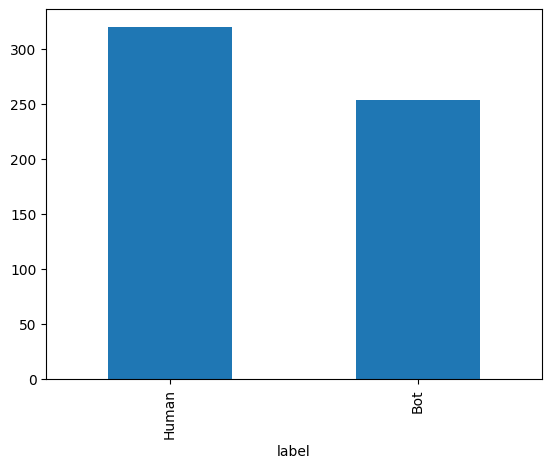

In [42]:
df_test = pd.read_csv(f"{DATA_FOLDER}/{FEATURES_FILE}")
df_test.set_index('contributor', inplace=True)
df_test = df_test[df_test['dataset'] == 'test']
df_test.drop(columns=['dataset'], inplace=True)

df_test['label'].value_counts().plot(kind='bar')
display(df_test.head())

In [43]:
df_label = df_test.copy()
df_label = df_label[['label']]
display(df_label.head())

df_test.drop(columns=['label'], inplace=True)

,label
contributor,
svedova,Human
jarka,Human
jprovaznik,Human
eduardobonet,Human
dmeshcharakou,Human


# 2 - Load the model

In [44]:
model = joblib.load(f"{MODEL_FOLDER}/{MODEL_NAME}")

# 3 - Predict the labels

In [45]:
from rabbit import compute_confidence
import warnings


def predict(features, model):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        proba = model.predict_proba(features)
    return compute_confidence(proba[0][1])

In [46]:
# Create a df with 4 column but with the "contributor" column as index
df_prediction = pd.DataFrame(columns=['true_bot', 'predicted_bot'])
df_prediction = df_prediction.astype(int)

for contributor in df_test.index:
    true_bot = df_label.loc[contributor, 'label']
    y_prediction, confidence = predict(df_test.loc[[contributor]], model)
    new_row = pd.DataFrame([{
        'contributor': contributor,
        'true_bot': true_bot,
        'predicted_bot': y_prediction,
        'confidence': confidence
    }])
    # Set true_bot and predicted_bot as int
    new_row.set_index('contributor', inplace=True)
    df_prediction = pd.concat([df_prediction, new_row], ignore_index=False)

df_prediction.index.name = 'contributor'
display(df_prediction)

,true_bot,predicted_bot,confidence
contributor,,,
svedova,Human,Human,0.922
jarka,Human,Human,0.886
jprovaznik,Human,Human,0.839
eduardobonet,Human,Human,0.941
dmeshcharakou,Human,Human,0.887
...,...,...,...
manuel.bottini,Human,Bot,0.236
renovate-bot.davinkevin.fr,Bot,Bot,0.821
coqbot,Bot,Bot,0.730


# 4 - Save the predictions

In [47]:
if PRED_FILE:
    df_prediction.to_csv(f"{EVAL_FOLDER}/{PRED_FILE}", index=True)
else:
    print("No file to save the predictions")

# 5 - Evaluate the predictions

## 5.1 - Define the metrics

In [48]:
def evaluate_model(y_pred, y_true, target_names):
    """
    Compute the classification metrics and return them as a DataFrame. The accuracy is also returned.
    :return: report_df and the accuracy.
    """
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    return {
        'precision': [report['weighted avg']['precision']],
        'bot_precision': [report['Bot']['precision']],
        'human_precision': [report['Human']['precision']],
        'recall': [report['weighted avg']['recall']],
        'bot_recall': [report['Bot']['recall']],
        'human_recall': [report['Human']['recall']],
        'weighted_f1': [report['weighted avg']['f1-score']],
        'accuracy': [report['accuracy']],
        'roc_auc': [roc_auc_score(y_true, y_pred)],
        'tn_fp_fn_tp': [confusion_matrix(y_true, y_pred).ravel()],
        'num_contrib': [df_prediction.index.nunique()],
    }

## 5.2 - Evaluate the predictions

In [49]:
contributor_map = {
    'Bot': 1,
    'Human': 0
}

df_prediction['predicted_bot'] = df_prediction['predicted_bot'].map(contributor_map)
df_prediction['true_bot'] = df_prediction['true_bot'].map(contributor_map)
# Set column type to int
df_prediction['predicted_bot'] = df_prediction['predicted_bot'].astype(int)
df_prediction['true_bot'] = df_prediction['true_bot'].astype(int)

y_pred = df_prediction['predicted_bot']
y_test = df_prediction['true_bot']



performance = pd.DataFrame.from_dict(evaluate_model(y_pred, y_test, ['Human', 'Bot']))
performance.index = [NAME]
performance['mapping'] = MAPPING_NAME

In [50]:
display(performance)

,precision,bot_precision,human_precision,recall,bot_recall,human_recall,weighted_f1,accuracy,roc_auc,tn_fp_fn_tp,num_contrib,mapping
bimbis,0.949285,0.902174,0.986532,0.945899,0.98419,0.915625,0.946067,0.945899,0.949907,"[293, 27, 4, 249]",573,glmap


## 5.3 - Save the evaluation

In [51]:
# Round the values
performance = performance.round(6)

In [52]:
df_eval = pd.read_csv(f"{EVAL_FOLDER}/{EVAL_FILE}", index_col=0)

In [53]:
# If the evaluation already exists, replace the line
if NAME in df_eval.index:
    df_eval.drop(index=NAME, inplace=True)
df_eval = pd.concat([df_eval, performance], axis=0)
df_eval.index.name = 'model'
df_eval.to_csv(f"{EVAL_FOLDER}/{EVAL_FILE}", index=True)